In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import scipy.stats as st
import os
import numpy as np
import random
from scipy.stats import linregress
from scipy.stats import pearsonr
import hvplot.pandas
import requests

In [2]:
movie_df = pd.read_csv('movies_awards.csv')
movie_df.shape

(5579, 21)

In [3]:
# Identify duplicate movie titles
duplicate_titles = movie_df[movie_df.duplicated(subset='Movie_Title', keep=False)]
title_counts = duplicate_titles['Movie_Title'].value_counts()
print(title_counts)

Movie_Title
Little Women            6
West Side Story         4
The Great Gatsby        4
Robin Hood              3
A Star Is Born          3
                       ..
Hummingbird             2
Red Dawn                2
The Three Musketeers    2
Godzilla                2
Black Sheep             2
Name: count, Length: 113, dtype: int64


In [4]:
# Drop Duplicates
df_unique = movie_df.drop_duplicates(subset='Movie_Title', keep='first')
df_unique.shape

(5453, 21)

In [5]:
filter_criteria = (
    (df_unique['Metascore'].notna()) &
    (df_unique['Box Office'].notna()) &
    (df_unique['Oscar Nomination'].notna()) & 
    (df_unique['Metascore'] != 'Rating not found') &  
    (df_unique['Box Office'] != 'Box Office not found')
)
clean_movie_df = df_unique[filter_criteria]
clean_movie_df.shape

(71, 21)

In [6]:
# Create a copy
clean_movie_df2 = clean_movie_df.copy()

# Convert 'Box Office' to numeric after removing $ and commas
clean_movie_df2['Box Office'] = clean_movie_df2['Box Office'].replace('[\$,]', '', regex=True).astype(int)

# Convert millions to a more readable format
clean_movie_df2['Box Office (in M)'] = (clean_movie_df2['Box Office'] / 1e6).round(1).astype(str) + 'M'

clean_movie_df2.head(1)

,Movie_Title,Year,Director,Actors,Rating,Runtime(Mins),Censor,Total_Gross,main_genre,side_genre,...,Rotten Tomatoes Rating,IMDb Rating,Metascore,Box Office,imdbID,Oscar Award,Oscar Nomination,Award Wins,Award Nominations,Box Office (in M)
1,The Dark Knight,2008,Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",9.0,152,UA,$534.86M,Action,"Crime, Drama",...,94%,9.0,84,534987076,tt0468569,2.0,8.0,163.0,164.0,535.0M


In [7]:
bins = [0, 100000000, 200000000, 300000000, 400000000, 500000000, 1000000000]
labels = ['0 - $100M', '100M - $200M', '200M - $300M', '300M - $400M', '$400M - $500M', 'Over $500M']
clean_movie_df2['Box Office Category'] = pd.cut(clean_movie_df2['Box Office'], bins, labels=labels, right=True, include_lowest=True)

In [8]:
clean_movie_df2.head(1)

,Movie_Title,Year,Director,Actors,Rating,Runtime(Mins),Censor,Total_Gross,main_genre,side_genre,...,IMDb Rating,Metascore,Box Office,imdbID,Oscar Award,Oscar Nomination,Award Wins,Award Nominations,Box Office (in M),Box Office Category
1,The Dark Knight,2008,Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",9.0,152,UA,$534.86M,Action,"Crime, Drama",...,9.0,84,534987076,tt0468569,2.0,8.0,163.0,164.0,535.0M,Over $500M


/var/folders/hs/gpfk35m163v8nk31_7kfcs640000gn/T/ipykernel_9356/1650970685.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_df = clean_movie_df2.groupby(['Oscar Nomination', 'Box Office Category']).size().unstack(fill_value=0)


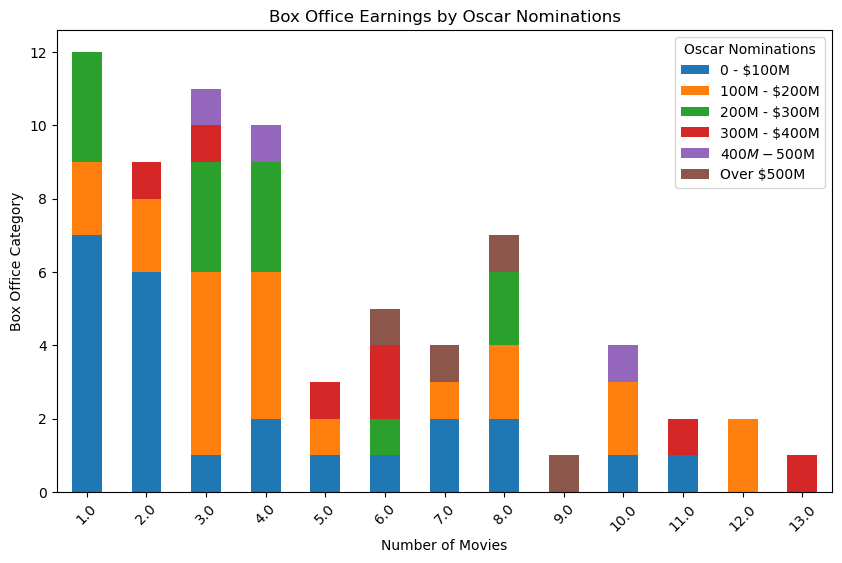

In [9]:
summary_df = clean_movie_df2.groupby(['Oscar Nomination', 'Box Office Category']).size().unstack(fill_value=0)

summary_df.plot(kind='bar', figsize=(10, 6), stacked=True)
plt.title('Box Office Earnings by Oscar Nominations')
plt.xlabel('Number of Movies')
plt.ylabel('Box Office Category')
plt.xticks(rotation=45)  
plt.legend(title='Oscar Nominations')
plt.show()

In [10]:
summary_df.head(15)

Box Office Category,0 - $100M,100M - $200M,200M - $300M,300M - $400M,$400M - $500M,Over $500M
Oscar Nomination,,,,,,
1.0,7,2,3,0,0,0
2.0,6,2,0,1,0,0
3.0,1,5,3,1,1,0
4.0,2,4,3,0,1,0
5.0,1,1,0,1,0,0
6.0,1,0,1,2,0,1
7.0,2,1,0,0,0,1
8.0,2,2,2,0,0,1
9.0,0,0,0,0,0,1


In [11]:
awards_wins_x = clean_movie_df2['Oscar Nomination']
box_office_y = clean_movie_df2['Box Office']

print('NaNs in Oscar Nomination:', awards_wins_x.isna().sum())
print('NaNs in Box Office:', box_office_y.isna().sum())
print('Infs in Oscar Nomination:', np.isinf(awards_wins_x).sum())
print('Infs in Box Office:', np.isinf(box_office_y).sum())

NaNs in Oscar Nomination: 0
NaNs in Box Office: 0
Infs in Oscar Nomination: 0
Infs in Box Office: 0


The r-value is PearsonRResult(statistic=0.3154616065336829, pvalue=0.007367887727307038)


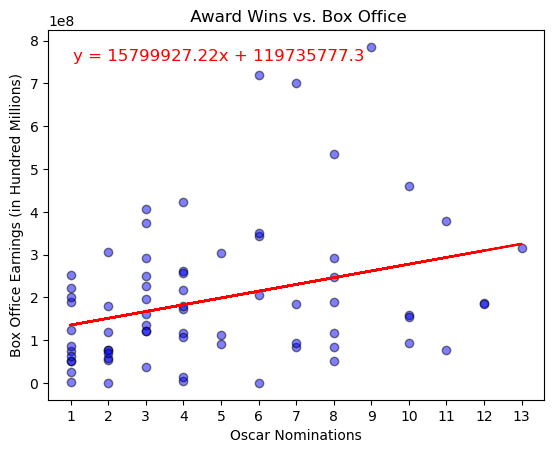

In [15]:
# Define my x and y axis
awards_wins_x = clean_movie_df2['Oscar Nomination']
box_office_y = clean_movie_df2['Box Office']

# Correlation
correlation = st.pearsonr(awards_wins_x, box_office_y) 

#Linear Regression
(slope, intercept, r_value, p_value, std_err) = linregress(awards_wins_x, box_office_y)
regress_values = awards_wins_x * slope + intercept
line_eq = f"y = {round(slope,2)}x + {round(intercept,2)}"

plt.scatter(awards_wins_x, box_office_y, 
            marker='o', 
            facecolors='blue', 
            edgecolors='black',
            alpha=0.5)

plt.plot(awards_wins_x, regress_values, "r-")  # Corrected to use regress_values
plt.annotate(line_eq, xy=(0.05, 0.95), xycoords='axes fraction',
             fontsize=12, color="red", verticalalignment='top')

ax = plt.gca() 
ax.yaxis.set_major_locator(ticker.MaxNLocator(10))
ax.xaxis.set_major_locator(ticker.MaxNLocator(15))

# Title, labels, and aesthetics
plt.title(' Award Wins vs. Box Office')
plt.xlabel('Oscar Nominations')
plt.ylabel('Box Office Earnings (in Hundred Millions)')
plt.grid(False)

print(f'The r-value is {correlation}')